In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bottleneck as bn
from numba import jit

import warnings
from scipy.special import comb
from scipy.stats import circmean,circstd # circular statistics
from sklearn.utils import resample # for bootstrapping
from itertools import combinations
from datetime import datetime,timedelta
from deformtools.haversine import haversine
# from deformtools.methods import least_square_method
# from deformtools.tools import ha

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import matplotlib.dates as mdates
import multiprocessing as mp
from time import time
import scipy.linalg as la

warnings.simplefilter('ignore')
sns.set(style='whitegrid', context='poster', font_scale=1.2)
%matplotlib inline 

In [3]:
class Polygon:
    
    def __init__(self,i,comb,data):
        # initialize polygon
        #self.id = i
        #self.drifters=comb # indices of drifters in polygon
        self.lats=data.lat.values
        self.lons=data.lon.values
        self.com=np.array( [bn.nanmean(data.lon.values),bn.nanmean(data.lat.values)])
        #self.us=data.uv.real/100
        #self.vs=data.uv.imag/100
        self.length=[]
        self.aspect=[]
        self.angle=[]
    
    def p(self,i):
        # return coordinates of a point
        return [self.lons[i],self.lats[i]]
    
    def calc_lengths(self):
        lengths=[]
        ncc = len(self.lons)
        r = combinations(np.arange(ncc), 2) 
        
        k=0
        for i,j in r:
            lengths.append( haversine( self.p(i),self.p(j) ) )
            k+=1
            
        lengths=np.array(lengths)                   
        if np.sum(np.isfinite(lengths))==k:
            self.length = np.sqrt( np.mean(lengths**2) )
        else:
            self.length = np.nan           
    
    def least_square_method(self):
        #import gsw
        import scipy.linalg as la
        timeseries=True
        ncc = len(self.lons)
        dlon=[]
        dlat=[] 
        for i in range(ncc):
            # haversine(p1,p2)
            dlon.append(haversine( [self.lons[i],self.com[1]],self.com)*1000*np.sign(self.lons[i]-self.com[0]))
            dlat.append(haversine( [self.com[0],self.lats[i]],self.com)*1000*np.sign(self.lats[i]-self.com[1]))
        
        if not timeseries:
            R = np.mat( np.vstack( (np.ones((ncc,)) ,np.array(dlon), np.array(dlat) )).T )
            u0=np.mat(self.us).T
            v0=np.mat(self.vs).T

            A,_,_,_=la.lstsq(R,u0)
            B,_,_,_=la.lstsq(R,v0)
        
            self.A=A[1:]
            self.B=B[1:]

        points =np.vstack( [dlon,dlat] )
        if np.sum( np.isfinite(points))==2*npol:
            # careful with nans
            cov = np.cov(points)
            w,v = np.linalg.eig(cov)
            self.aspect = bn.nanmin(w)/bn.nanmax(w)
            
            ind = bn.nanargmax(w)
            self.angle = np.arctan(v[ind,1]/v[ind,0])*180/np.pi
            
        else:
            self.aspect=np.nan
            #self.angle=np.nan

In [4]:
def makePolygons(i):
    criteria2 = data_chosen.particle.isin(selected_co[i])
    return Polygon(i,selected_co[i],data_chosen[criteria2])

def calc_properties(i):
    results[i].calc_lengths()
    results[i].least_square_method() 
    return results[i]

@jit
def find_percentiles(data):
    alpha = 0.75 # 95% confidence interval
    ordered = np.sort(data)
    lo = np.percentile(ordered,100*(1-alpha)/2,)
    hi = np.percentile(ordered,100*(alpha+(1-alpha)/2))
    return lo,hi

In [5]:
pwd

'/Users/sebastianessink/Dropbox (MIT)/deform/notebooks/ipynb'

In [11]:
data_path = '../../data/drifters/'
data = pd.read_pickle(data_path+'/posveldata_all.pkl')
N = data.particle.unique().size
npol=3
Nnpol = comb(N,npol,exact=True)
sampling_times = pd.date_range(data.index.unique()[0], periods=32, freq='6H')
T = len(sampling_times)
print('N=%d, npol=%d, Nnpol=%d, T=%d' %(N,npol,Nnpol,T))

combs=[]
for combi in combinations(np.arange(N),npol):
    combs.append(combi)

N=45, npol=3, Nnpol=14190, T=32


In [12]:
res = np.load('../../data/clusters/initial_lengths.npy',allow_pickle=True)

(array([   31.,    71.,   148.,   399.,  1052.,  1939.,  3767.,  8472.,
        12964., 19355.]),
 array([2.934183142654578, 3.6407645716601156, 4.347346000665653,
        5.053927429671191, 5.7605088586767295, 6.467090287682266,
        7.173671716687805, 7.8802531456933425, 8.58683457469888,
        9.293416003704419, 9.999997432709955], dtype=object),
 <a list of 10 Patch objects>)

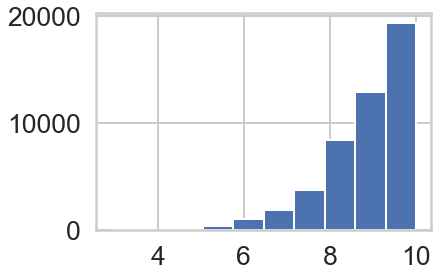

In [31]:
plt.hist( le[le<10])

In [32]:
len(le[le<10])

48198

In [13]:
len(res)
le = res[:,1] 
co = res[:,0]

selected_co = co[le<10]
npol=6

In [14]:
Nnpol = len(selected_co)

In [15]:
sampling_times

DatetimeIndex(['2015-09-03 00:00:00', '2015-09-03 06:00:00',
               '2015-09-03 12:00:00', '2015-09-03 18:00:00',
               '2015-09-04 00:00:00', '2015-09-04 06:00:00',
               '2015-09-04 12:00:00', '2015-09-04 18:00:00',
               '2015-09-05 00:00:00', '2015-09-05 06:00:00',
               '2015-09-05 12:00:00', '2015-09-05 18:00:00',
               '2015-09-06 00:00:00', '2015-09-06 06:00:00',
               '2015-09-06 12:00:00', '2015-09-06 18:00:00',
               '2015-09-07 00:00:00', '2015-09-07 06:00:00',
               '2015-09-07 12:00:00', '2015-09-07 18:00:00',
               '2015-09-08 00:00:00', '2015-09-08 06:00:00',
               '2015-09-08 12:00:00', '2015-09-08 18:00:00',
               '2015-09-09 00:00:00', '2015-09-09 06:00:00',
               '2015-09-09 12:00:00', '2015-09-09 18:00:00',
               '2015-09-10 00:00:00', '2015-09-10 06:00:00',
               '2015-09-10 12:00:00', '2015-09-10 18:00:00'],
              dtype='da

In [47]:
results=[]

mean_length=np.zeros(T)
median_length=np.zeros(T)
std_length=np.zeros(T)
lo_length=np.zeros(T)
hi_length=np.zeros(T)

median_aspect=np.zeros(T)
mean_aspect=np.zeros(T)
lo_aspect=np.zeros(T)
hi_aspect=np.zeros(T)


start = time()
for t,tim in enumerate(sampling_times):
    
    results=[]
    if tim in data.index:
              
        # select subset in time
        data_chosen = data[data.index == tim]
        
        # make polygons
        results=[]
        pool = mp.Pool(8)     
        results = pool.map(makePolygons, range(Nnpol))
        pool.close()
        pool.join()
        
        # calculate properties
        pool = mp.Pool(8)     
        results = pool.map(calc_properties, range(Nnpol))
        pool.close()
        pool.join()
        
        # read geometry data
        asp = np.array([results[i].aspect for i in range(Nnpol)]).squeeze()
        ang = np.array([results[i].angle for i in range(Nnpol)]).squeeze()
        leng = np.array([results[i].length for i in range(Nnpol)]).squeeze()
        
        mean_length[t] = bn.nanmean(leng)
        std_length[t] = bn.nanstd(leng)
        median_length[t] = bn.nanmedian(leng)
        if np.isfinite(leng).sum()>0:
            lo_length[t],hi_length[t] = find_percentiles(leng[np.isfinite(leng)])
        else:
            lo_length[t],hi_length[t] = np.nan, np.nan
            
        mean_aspect[t] = bn.nanmean(asp)
        median_aspect[t] = bn.nanmedian(asp)
        if np.isfinite(asp).sum()>0:
            lo_aspect[t],hi_aspect[t] = find_percentiles(asp[np.isfinite(asp)])
        else:
            lo_aspect[t],hi_aspect[t] = np.nan, np.nan
        
        if np.mod(t,4)==0:
            print('1 step in %d %3.3f minutes' %(t,(time()-start)/60) )
        
    else:
        print('no data at that time.')
        
print('save data' )
df=[]
df = pd.DataFrame(index=sampling_times,data={'mean_length':mean_length,'median_length':median_length,'lo_length':lo_length,'hi_length':hi_length,
                                     'mean_aspect':mean_aspect,'median_aspect':median_aspect,'lo_aspect':lo_aspect,'hi_aspect':hi_aspect})

df['dtime']=df.index-df.index[0]
# df['dtime']=df.dtime.dt.days.values
fname = 'deformation_n_6_T_90d_split_%d.pkl' %t
df.to_pickle(data_path+fname)
    
print('total %3.3f minutes' %((time()-start)/60) )

1 step in 0 0.234 minutes
1 step in 4 1.344 minutes
1 step in 8 2.874 minutes
1 step in 12 4.507 minutes
1 step in 16 5.998 minutes
1 step in 20 8.504 minutes
1 step in 24 10.191 minutes
1 step in 28 11.518 minutes
save data
total 12.642 minutes
